In [ ]:
import time
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

!pip install 'tensorflow==1.15.0'
import tensorflow as tf

!pip install 'kaggle_environments'
from kaggle_environments import make, evaluate

from gym import spaces

!apt-get update
!apt-get install -y cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install "stable-baselines[mpi]==2.9.0"

from stable_baselines.bench import Monitor 
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO1, A2C, ACER, ACKTR, TRPO
from stable_baselines.a2c.utils import conv, linear, conv_to_fc
from stable_baselines.common.policies import CnnPolicy

In [61]:
class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1)
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns,1), reward, done, _

In [89]:
# Create ConnectFour environment
env = ConnectFourGym(agent2=random_learner)

# Create directory for logging training information
log_dir = "log/"
os.makedirs(log_dir, exist_ok=True)

# Logging progress
monitor_env = Monitor(env, log_dir, allow_early_resets=True)

# Create a vectorized environment
vec_env = DummyVecEnv([lambda: monitor_env])

# Neural network for predicting action values
def modified_cnn(scaled_images, **kwargs):
    activ = tf.nn.relu
    layer_1 = activ(conv(scaled_images, 'c1', n_filters=32, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = activ(conv(layer_1, 'c2', n_filters=64, filter_size=3, stride=1, 
                         init_scale=np.sqrt(2), **kwargs))
    layer_2 = conv_to_fc(layer_2)
    return activ(linear(layer_2, 'fc1', n_hidden=512, init_scale=np.sqrt(2)))  

class CustomCnnPolicy(CnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, cnn_extractor=modified_cnn)

Next, run the code cell below to train an agent with PPO and view how the rewards evolved during training.  This code is identical to the code from the tutorial.

In [90]:
# Initialize agent
model = PPO1(CustomCnnPolicy, vec_env, verbose=0)

In [108]:
# Train agent
start = time.time()
n_steps = 50000 #100000
model.learn(total_timesteps=n_steps) 
print ("Learning took",time.time()-start,"seconds for",n_steps,"steps.")

Learning took 282.98467993736267 seconds for 50000 steps.


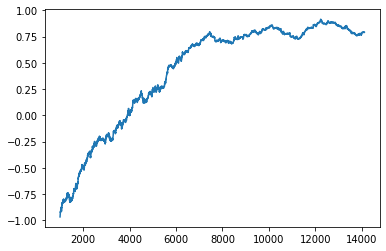

In [110]:
# Plot cumulative reward
with open(os.path.join(log_dir, "monitor.csv"), 'rt') as fh:    
    firstline = fh.readline()
    assert firstline[0] == '#'
    df = pd.read_csv(fh, index_col=None)['r']
df.rolling(window=1000).mean().plot()
plt.show()

If your agent trained well, the plot (which shows average cumulative rewards) should increase over time.

Once you have verified that the code runs, try making amendments to see if you can get increased performance.  You might like to:
- change `PPO1` to `A2C` (or `ACER` or `ACKTR` or `TRPO`) when defining the model in this line of code: `model = PPO1(CustomCnnPolicy, vec_env, verbose=0)`.  This will let you see how performance can be affected by changing the algorithm from Proximal Policy Optimization [PPO] to one of:
  - Advantage Actor-Critic (A2C),
  - or Actor-Critic with Experience Replay (ACER),
  - Actor Critic using Kronecker-factored Trust Region (ACKTR), or 
  - Trust Region Policy Optimization (TRPO).
- modify the `change_reward()` method in the `ConnectFourGym` class to change the rewards that the agent receives in different conditions.  You may also need to modify `self.reward_range` in the `__init__` method (this tuple should always correspond to the minimum and maximum reward that the agent can receive).
- change `agent2` to a different agent when creating the ConnectFour environment with `env = ConnectFourGym(agent2="random")`.  For instance, you might like to use the `"negamax"` agent, or a different, custom agent.  Note that the smarter you make the opponent, the harder it will be for your agent to train!

In [86]:
#learned_model = model
def random_learner(obs, config):
    # Use the best model to select a column
    col, _ = learned_model.predict(np.array(obs['board']).reshape(6,7,1))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In [109]:
def my_agent(obs, config):
    # Use the best model to select a column
    col, _ = model.predict(np.array(obs['board']).reshape(6,7,1))
    # Check if selected column is valid
    is_valid = (obs['board'][int(col)] == 0)
    # If not valid, select random move. 
    if is_valid:
        return int(col)
    else:
        return random.choice([col for col in range(config.columns) if obs.board[int(col)] == 0])

In the next code cell, we see the outcome of one game round against a random agent.

In [ ]:
# Create the game environment
#env = make("connectx")

# Two random agents play one game round
#env.run([random_learner,"random"])
#env.render(mode="ipython")

#env.play([None, "random"])

And, we calculate how it performs on average, against the random agent.

In [87]:
def get_win_percentages(agent1, agent2, n_rounds=1):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [115]:
start_time = time.time()
n_rounds=1000
get_win_percentages(agent1=my_agent, agent2="negamax", n_rounds=n_rounds)
print ("Total time taken: {} seconds".format(time.time() - start_time))
print ("Time taken per round: {} seconds".format((time.time() - start_time)/n_rounds))
#Total time taken at Kaggle: 51.1 seconds

Agent 1 Win Percentage: 0.02
Agent 2 Win Percentage: 0.96
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
Total time taken: 888.9220097064972 seconds
Time taken per round: 0.8889221034049988 seconds


#Second run

##random_learner vs. my_agent

*my_agent* trained against pre-trained *random_learner*

-----------------------
### Pretrain

~30000 steps

* random agent Win Percentage: 0.36
* random_learner Win Percentage: 0.64

Total time taken: 35.3 seconds

Time taken per round: 0.035 seconds

------------------------
### Model vs Model
~11000 steps

* my_agent Win Percentage: 0.4
* random_learner Win Percentage: 0.6

Total time taken: 46.0 seconds

Time taken per round: 0.046 seconds

------------------------
~50000 steps

* my_agent Win Percentage: 0.7
* random_learner Win Percentage: 0.3

Total time taken: 35.98 seconds

Time taken per round: 0.0359 seconds

------------------------
~140000 steps

* my_agent Win Percentage: 0.67
* random_learner Win Percentage: 0.33

Total time taken: 31.6 seconds

Time taken per round: 0.0316 seconds


#First run

##random_learner vs. my_agent

*my_agent* trained against pre-trained *random_learner*

-----------------------

10000 steps

* my_agent Win Percentage: 0.58
* random_learner Win Percentage: 0.42

Total time taken: 27.8 seconds

Time taken per round: 0.0278 seconds

------------------------

100000 steps

* my_agent Win Percentage: 0.62
* random_learner Win Percentage: 0.38


Total time taken: 32.3 seconds

Time taken per round: 0.032 seconds

------------------------
